### generating then ranking audio
- load the CNN model (or some other ranker) from feature_extraction 
- genereate parameters and its corresponding audio "randomly"
- rank the parameters using the ranker
- save the parameters that made the sound along with the rankings to some dataframe

In [45]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *
###
import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
###
import scipy.stats as ss
import common_vars as comv
import imp
import librosa
import librosa.display
import sys
sys.path.append("..")
import imp
import helpers
imp.reload(helpers)
imp.reload(comv)

from feature_extraction import pytorch_models as tm
imp.reload(tm)
from helpers import *

from common_vars import sr
SR=sr
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}


# function to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [47]:
input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

model = tm.LSTM(input_dim,seq_dim,hidden_dim, n_layers,output_size,device=device)
state='./feature_extraction/models/lstm/state_dict%d-%d-%d.pt'%(n_layers,hidden_dim,345)
model.load_state_dict(torch.load(state))
model.to(device)

#env model stuff
H1,H2,H3,H4,H5=31,15,10,5,2
env_model = tm.env_Model(D_in=31,H1=4,H2=2,H3=2,H4=10,H5=10)
state='./feature_extraction/models/fc/env_state-86.pt'
env_model.load_state_dict(torch.load(state))

env_trans=tm.envTrans(30)


# freak model stuff
freq_model=tm.freq_model(100,100,100)
state='./feature_extraction/models/fc/freq_state-0-85.pt'
freq_model.load_state_dict(torch.load(state))
freq_trans=tm.freqTrans()


# pitch model stuff
pitch_model=tm.pitch_model(D_in=20*21,H1=400,H2=200,H3=100,H4=50,H5=10)
state='./feature_extraction/models/fc/pitch_state-97.pt'
pitch_model.load_state_dict(torch.load(state))
pitch_trans=tm.pitchTrans(20)


tensor([0.7774, 0.2226], grad_fn=<SoftmaxBackward>) tensor([0.9950, 0.0050], grad_fn=<SoftmaxBackward>) tensor([0.9327, 0.0673], grad_fn=<SelectBackward>)


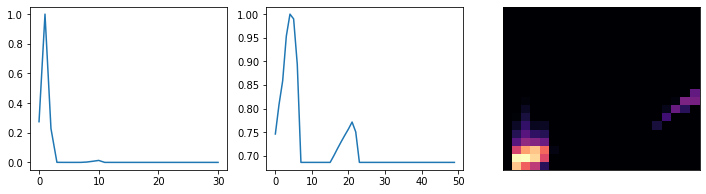

In [147]:

def findDrum():
    out,params= stackMaker(4)
    a= memToAud(out)

    at=a[0:SR//4]
    transform_input= {"signal":torch.tensor(at,dtype=torch.float),"label":torch.tensor(0)}
    
    env_feats=env_trans.call(transform_input)["feats"]
    freq_feats=freq_trans.call(transform_input)["feats"]
    pitch_feats=pitch_trans.call(transform_input)["feats"]
    
    return (at,env_model(env_feats),freq_model(freq_feats),env_feats,freq_feats,
            pitch_model(torch.flatten(pitch_feats, start_dim=1))[0],pitch_feats)

fig = plt.figure(figsize=(12,3))
while True:
    at,outputE,outputF,env_feats,freq_feats,outputP,pitch_feats=findDrum() 

    if (outputE[0]>0.7 and outputF[0]>0.7 and outputP[0]>0.7) and (outputE[0]+outputF[0]+outputP[0]>2):
        break

print(outputE,outputF,outputP)
ax = plt.subplot(1, 3,1)
plt.plot(env_feats)
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats)
ax=plt.subplot(1,3,3)
librosa.display.specshow(pitch_feats[0].numpy())
Audio(at[0:15000],rate=sr, autoplay=True)

tensor([0.9444, 0.0556], grad_fn=<SoftmaxBackward>)


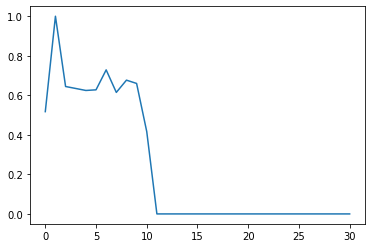

In [19]:
def findDrum():
    out,params= stackMaker(8)
    a= memToAud(out)

    at=a[0:SR//4]
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    a_feats=env_trans.call(transform_input)["feats"]
    return a,env_model(a_feats),a_feats

while True:
    a,output,a_feats=findDrum()    
    # get the image for that audio
#     a,num_trimmed=cutAudio(a)
#     im=audToImage(a,num_bins=NUM_BINS)
#     im=librosa.util.normalize(im)
#     plt.imshow(im)
    
    if output[0]>0.7:
        break

print(output)
plt.plot(a_feats.numpy())
Audio(a[0:15000],rate=sr, autoplay=True)

In [26]:
%%time
# from feature_extraction import mir_utils
# make a row of data and show what's going on

def makeRowSlow():
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params= stackMaker(3)
    a= memToAud(out)
   
    a,num_trimmed=cutAudio(a)
    
    dimg=z.to(device)
    h = model.init_hidden(0,device)
    h2 = tuple([e.data for e in h])
    outputs,h=model(dimg,h2)
    _, predicted = torch.max(outputs, 1)
    o=outputs.cpu().detach().numpy()[0]
    
    #normalize scores
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]), paramToDF(params)],axis=1) 
#     print(sorted(score_dict.items(), key=lambda x: x[1],reverse=True))

    return a,score_dict,params,df,z
counter=0
while True:
    counter=counter+1
    a,score_dict,params,df,image=makeRowSlow()
    s=sorted(score_dict.items(), key=lambda x: x[1],reverse=True)
    if s[0][0]!="stacks":
        print(s)
        print("after counts",counter)
        break
    
# librosa.display.waveplot(a)

Audio(a,rate=sr, autoplay=True)

NameError: name 'z' is not defined

#### here's what a row looks like, next print rows like this without the headers so we can redirect it to a csv/text file

In [48]:
df.columns

Index(['clap_rank', 'hat_rank', 'kick_rank', 'snare_rank', 'stacks_rank',
       'clap', 'hat', 'kick', 'snare', 'stacks', 'oscType_0', 'isNoise_0',
       'A_0', 'D_0', 'S_0', 'R_0', 'pitch_0_0', 'pitch_1_0', 'pitch_2_0',
       'pitch_3_0', 'bpCutLow_0', 'bpCutHigh_0', 'bpOrder_0', 'amplitude_0',
       'start_0', 'length_0', 'oscType_1', 'isNoise_1', 'A_1', 'D_1', 'S_1',
       'R_1', 'pitch_0_1', 'pitch_1_1', 'pitch_2_1', 'pitch_3_1', 'bpCutLow_1',
       'bpCutHigh_1', 'bpOrder_1', 'amplitude_1', 'start_1', 'length_1',
       'oscType_2', 'isNoise_2', 'A_2', 'D_2', 'S_2', 'R_2', 'pitch_0_2',
       'pitch_1_2', 'pitch_2_2', 'pitch_3_2', 'bpCutLow_2', 'bpCutHigh_2',
       'bpOrder_2', 'amplitude_2', 'start_2', 'length_2'],
      dtype='object')

In [180]:
%%time
from feature_extraction.mir_utils import audToImage
from helpers import *

# make a lot of rows, this can be run as its own script if you want to do multi-processing
for i in range(100):
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params=stackMaker(1)
    a=memToAud(out)
    # get the image for that audio
    try:
        im=mu.audToImage(a,128)
    except:
        pass
    z=librosa.util.normalize(im)

    #normalize array->pilform ->apply transoforms,
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    images=z.reshape([1,1,120,100])

    dimg=images.to(device)
    outputs=model(dimg,)
    _, predicted = torch.max(outputs, 1)

    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]),paramToDF(params)],axis=1)    
    x=df.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    
    print(df)

TypeError: forward() missing 1 required positional argument: 'hidden'